In [1]:
# png_png_512resize_binary_labelsplit_220728 : 1UDxZgD07fQrtR7jTkZRA5upnTo6p2PUZ

In [2]:
!gdown 1UDxZgD07fQrtR7jTkZRA5upnTo6p2PUZ

Downloading...
From: https://drive.google.com/uc?id=1UDxZgD07fQrtR7jTkZRA5upnTo6p2PUZ
To: /content/png_png_512resize_binary_labelsplit_220728.zip
100% 274M/274M [00:01<00:00, 142MB/s]


In [ ]:
!unzip /content/png_png_512resize_binary_labelsplit_220728.zip

In [35]:
from PIL import Image
import numpy as np
import os


images = []
img_dir = '/content/make_data/3/images/'
img_list = os.listdir(img_dir)

for i in img_list:
    dir = img_dir + i
    img = Image.open(dir).convert('L')
    # img = img.reshape()
    # np.append(images, img)
    
    img = np.array(img, dtype=np.int)
    img = np.reshape(img, (1,) + img.shape)
    images.append(img)
    # np.append(images, np.array(img), axis=0)


masks = []
mask_dir = '/content/make_data/3/masks/'
mask_list = os.listdir(mask_dir)

for i in mask_list:
    dir = mask_dir + i
    mask = Image.open(dir).convert('L')
    mask = np.array(mask, dtype=np.int)
    mask = np.where(mask < 255 ,0 , 1 )
    mask = np.reshape(mask, (1,) + mask.shape)
    masks.append(mask)

In [36]:
len(images), len(masks)

(188, 188)

In [37]:
masks[0].shape, images[0].shape

((1, 512, 512), (1, 512, 512))

In [ ]:
images

In [39]:
masks[0].max()

1

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

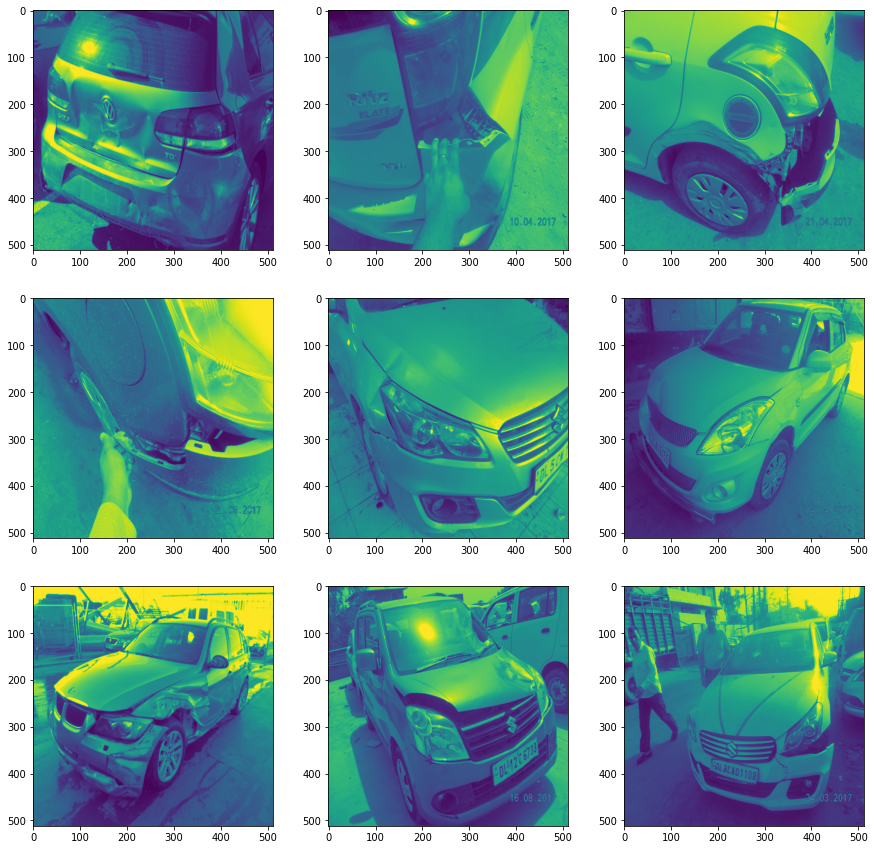

In [56]:
sample_number = 9
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(sample_number):
    subplot = ax[int(i//3), int(i%3)]
    subplot.imshow(images[i][0])
    
plt.show()

In [57]:
trainset = np.column_stack((images, masks))  # shape ( ? , ? )
print(trainset.shape)
# 3064x3x512x512


(188, 2, 512, 512)


In [58]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(trainset, test_size = 0.1)
trainset, validset = train_test_split(trainset, test_size = 0.05)
print('size of trainset, testset and validset is',len(trainset), len(testset), len(validset))

size of trainset, testset and validset is 160 19 9


In [59]:
import torch
import torch.nn as nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "cpu"
batch_size = 2
workers = 4
print("device available: ", device)       

device available:  cuda:0


In [60]:
import torchvision.transforms as transform
import torchvision.transforms.functional as TF
import random
from PIL import Image

random.seed(123)

class Resize(object):
    def __init__(self, size=512):
        self.size = size
    
    def __call__(self, sample):
        image, mask = sample
        image = TF.resize(image, size=(self.size, self.size), interpolation=Image.NEAREST)
        mask = TF.resize(mask, size = (self.size, self.size), interpolation=Image.NEAREST)
        return image, mask
    

class toPIL(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        image, mask = sample
        image = TF.to_pil_image(image.astype(np.float32))
        mask = TF.to_pil_image(mask.astype(np.float32))
        return image, mask

    
class toTensor(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        image, mask = sample
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
    
    
class Rotate(object):
    def __init__(self, p):
        self.p = p
        
    def __call__(self, sample):
        image, mask = sample
        if random.random() < self.p:
            angle = random.randint(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        return image, mask
    
    
class Flip(object):
    def __init__(self, p):
        self.p = p
        
    def __call__(self, sample):
        image, mask = sample
        if random.random() < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        return image, mask
    

class Crop(object):
    def __init__(self, p):
        self.p = p
    
    def __call__(self, sample):
        image, mask = sample
        if random.random() < self.p:
            size = image.size[1]
            crop_size = random.randint(int(size*0.5), size)
            image = TF.center_crop(image, output_size=crop_size)
            mask = TF.center_crop(mask, output_size=crop_size)
        return image, mask
    
    
class Padding(object):
    def __init__(self, size):
        super(Padding, self).__init__()
        self.size = size
        
    def __call__(self, sample):
        image, mask = sample
        w, h = image.size
        if (w < self.size):
            image = TF.pad(image, padding = (self.size-w)//2, fill=0)
            mask = TF.pad(mask, padding = (self.size-w)//2, fill=0)
        return image, mask
    
class ZoomOut(object):
    def __init__(self, p):
        super(ZoomOut, self).__init__()
        self.p = p
        
    def __call__(self, sample):
        image, mask = sample
        w, h = image.size
        if (random.random() < self.p):
            resize = Resize(random.randint(int(0.5*w), int(.95*w)))
            pad = Padding(w)
            sample = resize(sample)
            sample = pad(sample)
        return sample
    
    
def toNumpy(sample):
    image, mask = sample
    image = np.array(image)
    mask = np.array(mask)
    return image, mask


def normalize(sample):
    image, mask = sample
    m, s = np.mean(image), np.std(image)
    image = (image - m)/s
    return image, mask


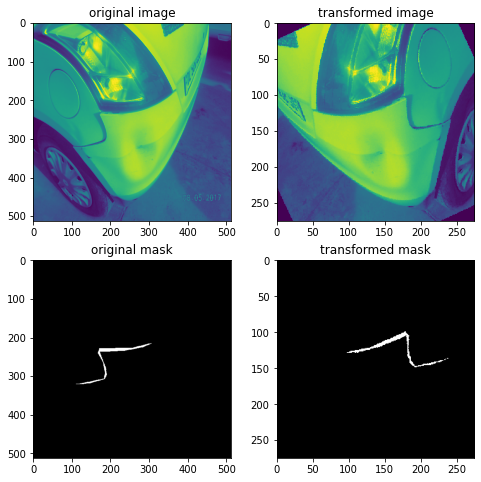

In [61]:
def getTransform(rotate, crop, flip, zoom):
    return transform.Compose([
        Rotate(rotate),
        ZoomOut(zoom),
        Crop(crop),
        Flip(flip),
    ])

func = toPIL()
testimg = func(trainset[0])
trans = getTransform(rotate=1, crop=1, flip=1, zoom=1 )
test = trans(testimg)
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(np.array(testimg[0]))
ax[0, 0].set_title("original image")
ax[0, 1].imshow(np.array(test[0]))
ax[0, 1].set_title('transformed image')
ax[1, 0].imshow(np.array(testimg[1]), cmap='gray')
ax[1, 0].set_title('original mask')
ax[1, 1].imshow(np.array(test[1]), cmap='gray')
ax[1, 1].set_title('transformed mask')
plt.show()

In [62]:
from torch.utils.data import Dataset, DataLoader
input_size = 512
class CarDataset(Dataset):
    def __init__(self, data, train=True, transform=None):
        self.data = data
        self.transform = transform
        self.train = train
        self.data = [normalize(i) for i in self.data]
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        sample = self.data[i]
        
        to_pil = toPIL()
        sample = to_pil(sample)
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        resize_func = Resize(input_size)
        sample = resize_func(sample)
        sample = toNumpy(sample)
        
        image, mask = sample
        # image, mask, label = sample
        # target_label = np.zeros((3, 1, 1))
        # target_label[label-1, 0, 0] = 1
        # label = target_label
                
        image = torch.from_numpy(image.astype(np.float32))
        mask = torch.from_numpy(mask.astype(np.float32))
        # label = torch.from_numpy(label.astype(np.float32))
        
        image = torch.unsqueeze(image, dim = 0).cpu()
        mask = torch.unsqueeze(mask, dim = 0).cpu()

        
        return image, mask
    
trainset = CarDataset(trainset, transform = getTransform(.8, .8, .8, .7)) 
testset  = CarDataset(testset)
validset = CarDataset(validset)

In [63]:
def getDataLoader(dataset, batch = batch_size):
    dataloader = DataLoader(
        dataset, 
        batch_size = batch,
        shuffle = True,
        num_workers = workers
    )
    return dataloader

testLoader  = getDataLoader(testset)
trainLoader = getDataLoader(trainset)
validLoader = getDataLoader(validset)

In [64]:
# 딥러닝 프레임워크 Tensorflow에서는 다음 함수를 통해 atrous convolution을 도입할 수 있다: tf.nn.atrous_conv2d

### Unet Basic

In [19]:
import os
import numpy as np

import torch
import torch.nn as nn

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=kernel_size, stride=stride, padding=padding,
                                    bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
       
        # Expansive path

        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                            kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                            kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                            kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        # self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)

        dec4_1 = self.dec4_1(enc4_1)
   
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        # x = self.fc(dec1_1)
        # x = x.cpu().data.numpy().argmax()

        return dec1_1

### Unet Basic 2

In [270]:
import os
import numpy as np

import torch
import torch.nn as nn

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=kernel_size, stride=stride, padding=padding,
                                    bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=4)
        self.dropout = nn.Dropout(0.25)
        self.enc1_2 = CBR2d(in_channels=4, out_channels=4)
        self.dropout = nn.Dropout(0.25)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=4, out_channels=8)
        self.dropout = nn.Dropout(0.25)
        self.enc2_2 = CBR2d(in_channels=8, out_channels=8)
        self.dropout = nn.Dropout(0.25)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=8, out_channels=16)
        self.dropout = nn.Dropout(0.25)
        self.enc3_2 = CBR2d(in_channels=16, out_channels=16)
        self.dropout = nn.Dropout(0.25)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=16, out_channels=32)
        self.dropout = nn.Dropout(0.25)
        self.enc4_2 = CBR2d(in_channels=32, out_channels=32)
        self.dropout = nn.Dropout(0.25)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=32, out_channels=64)
        self.dropout = nn.Dropout(0.25)
        self.enc5_2 = CBR2d(in_channels=64, out_channels=64)
        self.dropout = nn.Dropout(0.25)

        self.pool5 = nn.MaxPool2d(kernel_size=2)

        self.enc6_1 = CBR2d(in_channels=64, out_channels=128)
        self.dropout = nn.Dropout(0.25)
        self.enc6_2 = CBR2d(in_channels=128, out_channels=128)
        self.dropout = nn.Dropout(0.25)

        self.pool6 = nn.MaxPool2d(kernel_size=2)

        self.enc7_1 = CBR2d(in_channels=128, out_channels=256)
        self.dropout = nn.Dropout(0.25)
        self.enc7_2 = CBR2d(in_channels=256, out_channels=256)
        self.dropout = nn.Dropout(0.25)

        self.pool7 = nn.MaxPool2d(kernel_size=2)

        self.enc8_1 = CBR2d(in_channels=256, out_channels=512)
        self.dropout = nn.Dropout(0.25)
       
        # Expansive path

        self.dec8_1 = CBR2d(in_channels=512, out_channels=256)
        self.dropout = nn.Dropout(0.25)

        self.unpool7 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                            kernel_size=2, stride=1, padding=1, bias=True)

        self.dec7_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dropout = nn.Dropout(0.25)
        self.dec7_1 = CBR2d(in_channels=256, out_channels=128)
        self.dropout = nn.Dropout(0.25)

        self.unpool6 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                            kernel_size=2, stride=1, padding=1, bias=True)

        self.dec6_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dropout = nn.Dropout(0.25)
        self.dec6_1 = CBR2d(in_channels=128, out_channels=64)
        self.dropout = nn.Dropout(0.25)

        self.unpool5 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                            kernel_size=2, stride=1, padding=1, bias=True)

        self.dec5_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dropout = nn.Dropout(0.25)
        self.dec5_1 = CBR2d(in_channels=64, out_channels=32)
        self.dropout = nn.Dropout(0.25)

        self.unpool4 = nn.ConvTranspose2d(in_channels=32, out_channels=32,
                                            kernel_size=2, stride=1, padding=1, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 32, out_channels=32)
        self.dropout = nn.Dropout(0.25)
        self.dec4_1 = CBR2d(in_channels=32, out_channels=16)
        self.dropout = nn.Dropout(0.25)

        self.unpool3 = nn.ConvTranspose2d(in_channels=16, out_channels=16,
                                            kernel_size=2, stride=1, padding=1, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 16, out_channels=16)
        self.dropout = nn.Dropout(0.25)
        self.dec3_1 = CBR2d(in_channels=16, out_channels=8)
        self.dropout = nn.Dropout(0.25)

        self.unpool2 = nn.ConvTranspose2d(in_channels=8, out_channels=8,
                                            kernel_size=2, stride=1, padding=1, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 8, out_channels=8)
        self.dropout = nn.Dropout(0.25)
        self.dec2_1 = CBR2d(in_channels=8, out_channels=4)
        self.dropout = nn.Dropout(0.25)

        self.unpool1 = nn.ConvTranspose2d(in_channels=4, out_channels=4,
                                            kernel_size=2, stride=1, padding=1, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 4, out_channels=4)
        self.dropout = nn.Dropout(0.25)
        self.dec1_1 = CBR2d(in_channels=4, out_channels=1)

        # self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_1 = self.dropout(enc1_1)
        enc1_2 = self.enc1_2(enc1_1)
        enc1_2 = self.dropout(enc1_2)
        
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_1 = self.dropout(enc2_1)
        enc2_2 = self.enc2_2(enc2_1)
        enc2_2 = self.dropout(enc2_2)

        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_1 = self.dropout(enc3_1)
        enc3_2 = self.enc3_2(enc3_1)
        enc3_2 = self.dropout(enc3_2)

        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_1 = self.dropout(enc4_1)
        enc4_2 = self.enc4_2(enc4_1)
        enc4_2 = self.dropout(enc4_2)

        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        enc5_1 = self.dropout(enc5_1)
        enc5_2 = self.enc5_2(enc5_1)
        enc5_2 = self.dropout(enc5_2)

        pool5 = self.pool5(enc5_2)

        enc6_1 = self.enc6_1(pool5)
        enc6_1 = self.dropout(enc6_1)
        enc6_2 = self.enc6_2(enc6_1)
        enc6_2 = self.dropout(enc6_2)

        pool6 = self.pool6(enc6_2)

        enc7_1 = self.enc7_1(pool6)
        enc7_1 = self.dropout(enc7_1)
        enc7_2 = self.enc7_2(enc7_1)
        enc7_2 = self.dropout(enc7_2)

        pool7 = self.pool7(enc7_2)

        enc8_1 = self.enc8_1(pool7)
        enc8_1 = self.dropout(enc8_1)



        dec8_1 = self.dec8_1(enc8_1)
        dec8_1 = self.dropout(dec8_1)
   
        unpool7 = self.unpool7(dec8_1)
        cat7 = torch.cat((unpool7, enc7_2), dim=1)
        dec7_2 = self.dec7_2(cat7)
        dec7_2 = self.dropout(dec7_2)
        dec7_1 = self.dec7_1(dec7_2)
        dec7_1 = self.dropout(dec7_1)


        unpool6 = self.unpool6(dec7_1)
        cat6 = torch.cat((unpool6, enc6_2), dim=1)
        dec6_2 = self.dec6_2(cat6)
        dec6_2 = self.dropout(dec6_2)
        dec6_1 = self.dec6_1(dec6_2)
        dec6_1 = self.dropout(dec6_1)

        unpool5 = self.unpool5(dec6_1)
        cat5 = torch.cat((unpool5, enc5_2), dim=1)
        dec5_2 = self.dec5_2(cat5)
        dec5_2 = self.dropout(dec5_2)
        dec5_1 = self.dec5_1(dec5_2)
        dec5_1 = self.dropout(dec5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_2 = self.dropout(dec4_2)
        dec4_1 = self.dec4_1(dec4_2)
        dec4_1 = self.dropout(dec4_1)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_2 = self.dropout(dec3_2)
        dec3_1 = self.dec3_1(dec3_2)
        dec3_1 = self.dropout(dec3_1)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_2 = self.dropout(dec2_2)
        dec2_1 = self.dec2_1(dec2_2)
        dec2_1 = self.dropout(dec2_1)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_2 = self.dropout(dec1_2)
        dec1_1 = self.dec1_1(dec1_2)


        # x = self.fc(dec1_1)
        # x = x.cpu().data.numpy().argmax()

        return dec1_1

### Unet Basic 3

### iou / dice

In [271]:
import copy
import csv
import os
import time

import numpy as np
import torch
from tqdm import tqdm


def prod_iou(pred, true):
    smooth = 1e-3
    numerator = ( pred * true ).sum() 
    denominator = pred.sum() + true.sum() - numerator
    iou_score = numerator / (denominator + smooth)
    # return np.array(iou_score)
    return iou_score



def dice_coef(y_pred, y_true):
    smooth = 1e-3
    numerator =   (2 * ( y_pred * y_true ).sum() + smooth)
    denominator = ( y_pred.sum() + y_true.sum()  + smooth)
    return numerator / denominator

def dice_loss(y_pred, y_true):
    return 1. - dice_coef(y_pred, y_true)

class dice(nn.Module):
    def __init__(self):
        super(dice, self).__init__()
        
    def forward(self, y_pred, y_true):
        return dice_loss(y_pred, y_true)

def dsc(y_pred, y_true):
    smooth = 1e-3
    y_pred, y_true = torch.round(y_pred), torch.round(y_true)
    numerator = (2 * ( y_pred * y_true ).sum() + smooth)
    denominator = ( y_pred.sum() + y_true.sum()  + smooth)
    return numerator / denominator

class bce_dice_loss(nn.Module):
    def __init__(self):
        super(bce_dice_loss, self).__init__()
        self.loss = nn.BCELoss()
        # self.loss = nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)

        
    def forward(self, mask_pred, mask_true):
        return dice_loss(mask_pred, mask_true)


In [272]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [273]:
# import tensorflow as tf

# def iou(y_true, y_pred):
#     smooth = 1.
#     y_true = tf.convert_to_tensor(y_true, dtype=None, dtype_hint=None, name=None).detach().cpu()
#     y_pred = tf.convert_to_tensor(y_pred, dtype=None, dtype_hint=None, name=None).detach().cpu()

#     y_true = tf.reshape(y_true, [-1]) # 2차원 이미지를 1차원으로 reshape
#     y_pred = tf.reshape(y_pred, [-1]) # 2차원 이미지를 1차원으로 reshape

#     intersection = tf.reduce_sum(y_true * y_pred) 
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

#     score  = intersection / (union + smooth)

#     return score

### Unet Training

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import warnings
warnings.filterwarnings(action='ignore')

unet = UNet()
unet.to(device)
adamW = optim.AdamW(unet.parameters(), lr=1e-3)
scheduler = StepLR(adamW, step_size=20, gamma=0.1)
epochs = 10
loss_func = bce_dice_loss()
train_loss_history = []
valid_loss_history = []
train_iou_history = []
valid_iou_history = []

best_valid = 1e3

for epoc in range(epochs):
    print('------')
    print('epoch:', epoc + 1,'/',epochs)
    train_loss = []
    valid_loss = []
    train_iou = []
    valid_iou = []
    
    # train 
    unet.train()
    pbar = tqdm(trainLoader, total=int(len(trainset)//batch_size),position=0, leave=True)
    
    for data, mask in pbar:
        data, mask = data.to(device), mask.to(device)
        mask_pred= unet(data)
        adamW.zero_grad()
        loss = loss_func(mask_pred, mask)
        train_loss.append(loss.item())
        loss.requires_grad_(True)
        loss.backward()
        adamW.step()
        prod_IOU = prod_iou(mask_pred, mask)   ######

        train_iou.append(prod_IOU)
    train_loss_history.append(np.mean(train_loss))
        
    train_iou_history.append(np.mean(train_iou))    ########????????????????
    
 

    # valid 
    with torch.no_grad():
        unet.eval()
        for data, mask in validLoader:
            data, mask = data.to(device), mask.to(device)
            mask_pred= unet(data)
            loss = loss_func(mask_pred, mask)
            valid_loss.append(loss.item())
            prod_IOU = prod_iou(mask_pred, mask)   ######
            valid_iou.append(prod_IOU)
            
    valid_loss_history.append(np.mean(valid_loss))
    valid_iou_history.append(np.mean(valid_iou))    ########????????????????
    
    print('train loss:', train_loss_history[-1])
    print('valid loss:', valid_loss_history[-1])
    print('train_iou_score',train_iou_history)
    print('valid_iou_score',valid_iou_history)


    # save better model
    if (best_valid > valid_loss_history[-1]):
        best_valid = valid_loss_history[-1]
        torch.save(unet.state_dict(), os.path.join('./', 'unet_bin_L3.pt'))
        
    scheduler.step()

    
print('best validation loss:', best_valid)

# load model
state_dict = torch.load(os.path.join('./', 'unet_bin_L3.pt'))
unet.load_state_dict(state_dict);


In [ ]:
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR

# import warnings
# warnings.filterwarnings(action='ignore')

# unet = Unet()
# unet.to(device)
# adam = optim.Adam(unet.parameters(), lr=1e-3)
# scheduler = StepLR(adam, step_size=20, gamma=0.1)
# epochs = 20
# loss_func = bce_dice_loss()
# train_loss_history = []
# valid_loss_history = []
# best_valid = 1e3

# for epoc in range(epochs):
#     print('------')
#     print('epoch:', epoc + 1,'/',epochs)
#     train_loss = []
#     valid_loss = []
    
#     # train 
#     unet.train()
#     pbar = tqdm(trainLoader, total=int(len(trainset)//batch_size),position=0, leave=True)
    
#     for data, mask in pbar:
#         data, mask = data.to(device), mask.to(device)
#         mask_pred= unet(data)
#         adam.zero_grad()
#         loss = loss_func(mask_pred, mask)
#         train_loss.append(loss.item())
#         loss.backward()
#         adam.step()
#     train_loss_history.append(np.mean(train_loss))
    
    
#     # valid 
#     with torch.no_grad():
#         unet.eval()
#         for data, mask in validLoader:
#             data, mask = data.to(device), mask.to(device)
#             mask_pred= unet(data)
#             loss = loss_func(mask_pred, mask)
#             valid_loss.append(loss.item())

#     valid_loss_history.append(np.mean(valid_loss))
#     print('train loss:', train_loss_history[-1])
#     print('valid loss:', valid_loss_history[-1])
    
#     # save better model
#     if (best_valid > valid_loss_history[-1]):
#         best_valid = valid_loss_history[-1]
#         torch.save(unet.state_dict(), os.path.join('./', 'unet_bin_L3.pt'))
        
#     scheduler.step()

    
# print('best validation loss:', best_valid)

# # load model
# state_dict = torch.load(os.path.join('./', 'unet_bin_L3.pt'))
# unet.load_state_dict(state_dict);


In [22]:
#save progess
from numpy import savetxt
savetxt('./train_loss_history.csv', train_loss_history, delimiter=',')
savetxt('./valid_loss_history.csv', valid_loss_history, delimiter=',')

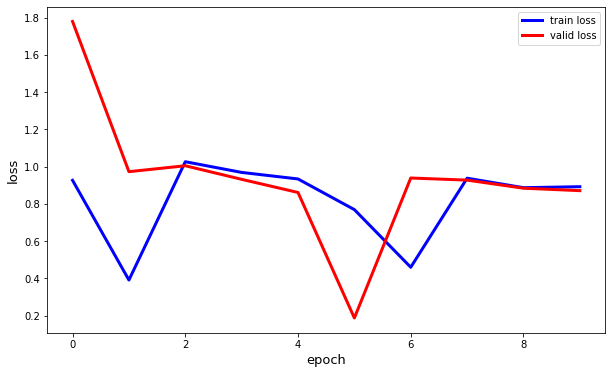

In [23]:
x = np.arange(epochs)

fig = plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_history, label='train loss', lw=3, color='blue')
plt.plot(x, valid_loss_history, label='valid loss', lw=3, color='red')
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend()
plt.show()

In [32]:
unet.eval()


with torch.no_grad():
    test_loss_dsc = []
    for img, mask, in testLoader:
        img, mask, = img.to(device), mask.to(device)
        mask_pred = unet(img)
        # class_pred = torch.argmax(label_pred, dim=1)
        # class_true = torch.argmax(label, dim=1)
        # correct = torch.flatten(class_pred == class_true)
        
        
        # mask_pred = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(correct, dim=1),dim=2), dim=3) * mask_pred
        loss = dsc(mask_pred, mask)
        test_loss_dsc.append(loss.item())
        
        
    print("test's dsc:", np.mean(test_loss_dsc))

test's dsc: -0.18378486726433038


In [33]:
def showRes(img, mask_pred, label_pred, mask):
    img, mask = img.detach().detach().cpu().numpy(), mask.detach().cpu().numpy()
    # # label = label.detach().cpu().numpy()
    # # mask_pred, label_pred = mask_pred.detach().cpu().numpy(), label_pred.cpu().numpy()
    mask_pred = np.round(mask_pred)
    # # label_pred = np.argmax(label_pred, axis=0)
    # # label_pred = label_pred.flatten()
    
    # # label = np.argmax(label, axis=0)
    # # label = label.flatten()
    
    
    fig, ax = plt.subplots(2, 2, figsize=(6, 6))
    ax[0, 0].imshow(img[0])
    ax[0, 0].set_title('image')
    ax[0, 1].imshow(mask[0], cmap='gray')
    # ax[0, 1].set_title('gt ' + classes[label[0]])
    
    ax[1, 0].imshow(img[0])
    ax[1, 0].set_title('image')
    ax[1, 1].imshow(mask_pred[0], cmap='gray')
    # ax[1, 1].set_title('pred ' + classes[label_pred[0]])
 

In [34]:
def show_batch(img, pred, mask):
    mask_pred= pred
    for i in range(img.size()[0]):
        showRes(img[i], mask_pred[i], mask[i])

In [ ]:
with torch.no_grad():
    for img, mask in testLoader:
        img, mask = img.to(device), mask.to(device)
        pred = unet(img)
        show_batch(img, pred, mask)
        break